<a href="https://colab.research.google.com/github/lysk9884/colab-study/blob/main/Word_Cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 형태소 분석기를 설치합니다. (제일먼저 실행이 되어야함)


* 모든 코드는 각 실행단계별로 하나씩 천천히 실행되어야합니다.

In [ ]:
!apt-get -qq update
!apt-get -qq install fonts-nanum
!apt-get -qq install fonts-noto-cjk
!apt-get -qq install mecab libmecab-dev mecab-ipadic-utf8 mecab-ipadic


!pip install konlpy pandas simplejson langdetect googletrans==4.0.0-rc1 wordcloud mecab-python3

Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 122093 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


2. 단어 분석을 수행할 파일을 업로드합니다 .csv 파일만 허용합니다.

In [ ]:
from google.colab import files

uploaded = files.upload()

targetCsv = "none";

for fn in uploaded.keys():
    print('User Uploaded File "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])));
    targetCsv = fn;

Saving 리뷰시트.csv to 리뷰시트 (4).csv
User Uploaded File "리뷰시트 (4).csv" with length 44035 bytes


3. 업로드된 csv 파일을 읽습니다.

In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded[targetCsv].decode('utf-8')))
df = df.reset_index()

4. 형태소를 분리합니다.

In [ ]:
import pandas as pd
from konlpy.tag import Kkma
from re import match, sub
from langdetect import detect
from googletrans import Translator
import MeCab
from collections import Counter
from wordcloud import WordCloud

kkma = Kkma()
mecab = MeCab.Tagger("-r /etc/mecabrc")
translator = Translator()

korean_nouns = []
japanese_nouns = []
english_nouns = []

def detect_language(text):
    lang = detect(text)
    if lang in ['ko', 'ja', 'en']:
        return lang
    return None

def is_only_symbols(text):
    return not bool(sub(r'[\W_]+', '', text))

def extract_nouns(text, lang):
    if lang == 'ko':
        return kkma.nouns(text)
    elif lang == 'ja':
        parsed = mecab.parse(text)
        return [line.split('\t')[0] for line in parsed.splitlines() if '\t' in line and '名詞' in line.split('\t')[-1]]
    elif lang == 'en':
        return [word for word in text.split() if word.isalpha()]
    else:
        return []

for index, row in df.iterrows():
    text = row[1]
    if not text or is_only_symbols(text):
        continue
    lang = detect_language(text)
    if not lang:
        continue
    ex_sent = [text]

    for sent in ex_sent:
        nouns = extract_nouns(sent, lang)
        for noun in nouns:
            if len(str(noun)) >= 2 and not match('^[0-9]', noun):
                if lang == 'ko':
                    korean_nouns.append(noun)
                elif lang == 'ja':
                    japanese_nouns.append(noun)
                elif lang == 'en':
                    english_nouns.append(noun)



5. 계산및 출력



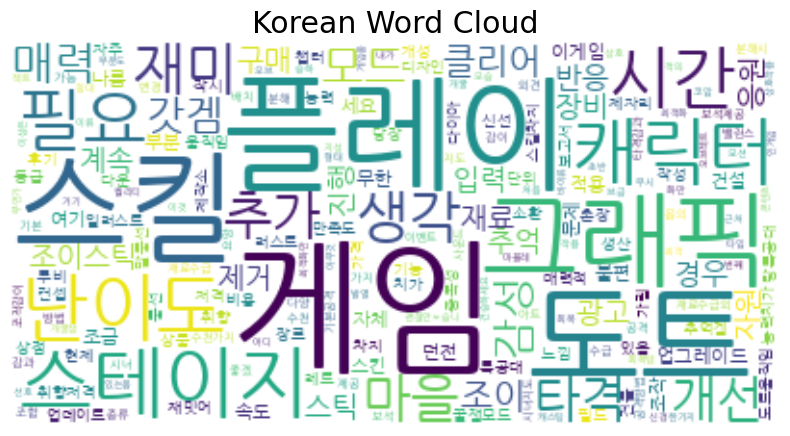

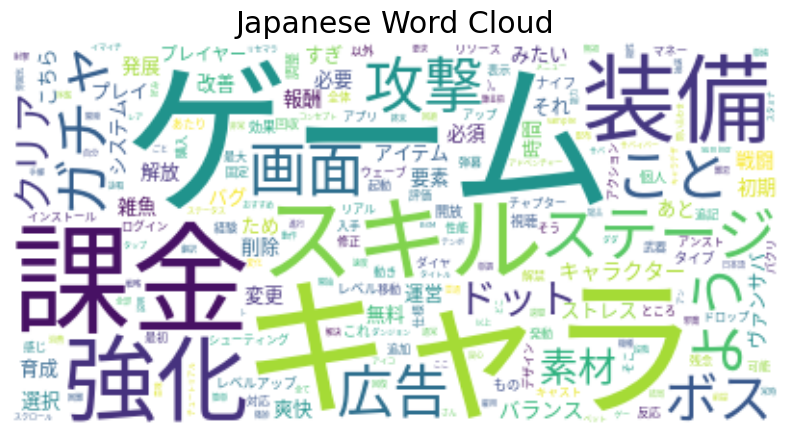

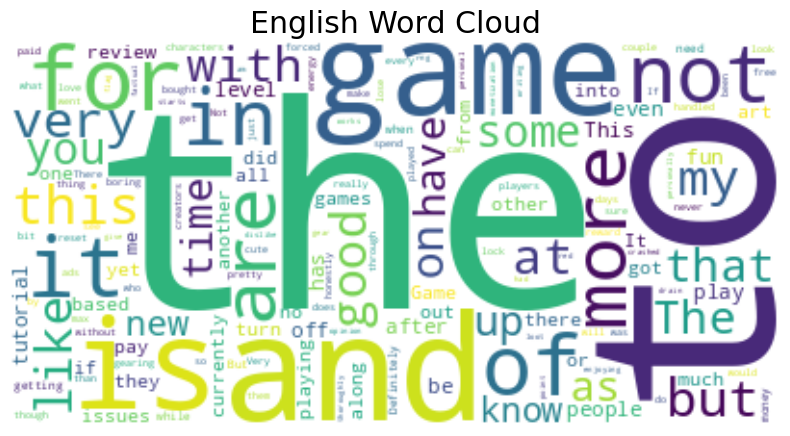

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

# 단어 빈도 계산
korean_word_count = Counter(korean_nouns)
japanese_word_count = Counter(japanese_nouns)
english_word_count = Counter(english_nouns)

# CSV 파일로 저장
pd.DataFrame(korean_word_count.items(), columns=["단어", "수"]).to_csv('korean_result.csv', index=False)
pd.DataFrame(japanese_word_count.items(), columns=["단어", "수"]).to_csv('japanese_result.csv', index=False)
pd.DataFrame(english_word_count.items(), columns=["단어", "수"]).to_csv('english_result.csv', index=False)

# 설치한 폰트를 사용할 수 있도록 설정
import matplotlib.font_manager as fm

# 한글 폰트 설정
fe_ko = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe_ko)

# 일본어 폰트 설정
fe_ja = fm.FontEntry(
    fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
    name='NotoSansCJK')
fm.fontManager.ttflist.insert(0, fe_ja)

plt.rcParams.update({'font.size': 18})

# 워드 클라우드 생성
korean_wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', relative_scaling=.3, background_color='white').generate_from_frequencies(korean_word_count)
japanese_wc = WordCloud(font_path='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', relative_scaling=.3, background_color='white').generate_from_frequencies(japanese_word_count)
english_wc = WordCloud(relative_scaling=.3, background_color='white').generate_from_frequencies(english_word_count)

# 한국어 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(korean_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Korean Word Cloud')
plt.show()

# 일본어 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(japanese_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Japanese Word Cloud')
plt.show()

# 영어 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(english_wc, interpolation='bilinear')
plt.axis('off')
plt.title('English Word Cloud')
plt.show()

# CSV 파일 다운로드
files.download('korean_result.csv')
files.download('japanese_result.csv')
files.download('english_result.csv')